# Argentina flights

In [27]:
import pandas as pd

df = pd.read_csv('ANAC-flights-2024.csv', skipinitialspace=True)

df.columns = df.columns.str.rstrip()

# Strip trailing spaces or tabs from all string values in the DataFrame
df = df.map(lambda x: x.rstrip() if isinstance(x, str) else x)

df.head()

,Fecha UTC,Hora UTC,Clase Vuelo,Clasificación,Tipo de Movimiento,Aeropuerto,Origen-Destino,Aerolinea,Aeronave,Pasajeros,PAX,Calidad dato
0,01/01/2024,0:02,Regular,Internacional,Aterrizaje,AER,SBGR,LATAM AIRLINES BRASIL (exTAM LA SA),0,145,145,DEFINITIVO
1,01/01/2024,0:02,Regular,Internacional,Aterrizaje,EZE,LFPG,AIR FRANCE,0,217,217,DEFINITIVO
2,01/01/2024,0:05,Regular,Internacional,Aterrizaje,EZE,LEMD,IBERIA - LINEAS AÉREAS DE ESPAÑA,0,168,168,DEFINITIVO
3,01/01/2024,0:08,Regular,Internacional,Despegue,EZE,KJFK,AMERICAN AIRLINES INC.,0,272,272,DEFINITIVO
4,01/01/2024,0:10,Regular,Internacional,Despegue,AER,SCEL,LATAM AIRLINES GROUP S.A.(exLAN AIRLINE),0,92,92,DEFINITIVO


| Column Title             | Data Type              | Description                                                                                                           |
|--------------------------|------------------------|-----------------------------------------------------------------------------------------------------------------------|
| Date                     | ISO-8601 Date (date)   | Flight date in UTC.                                                                                                   |
| UTC Time                 | ISO-8601 Time (time)   | UTC Time (Coordinated Universal Time). When evaluating this data, consider that Argentina's official time is UTC -3.   |
| Flight Class (all flights)| Text (string)         | Categories of flights                                                                                                 |
| Flight Classification    | Text (string)          | Classification of flight type: Domestic or International                                                              |
| Type of Movement         | Text (string)          | Classification of the type of movement. A "Movement" is considered to be an operation, either landing or takeoff.      |
| Airport                  | Text (string)          | Airport name FAA code                                                                                                 |
| Origin/Destination       | Text (string)          | FAA code for domestic airports and ICAO code for foreign airports.                                                    |
| Airline Name             | Text (string)          | Name of the airline                                                                                                   |
| Aircraft                 | Text (string)          | Code to identify aircraft manufacturers with the specific model designation of the airplane.                          |
| Passengers               | Integer (integer)      | Number of passengers for an individual operation (takeoff/landing). For domestic flights, both takeoff and landing are recorded. When analyzing an individual airport, this column should be used. |
| PAX                      | Integer (integer)      | 1 pax = 1 boarding pass. Use this column when analyzing the total number of domestic passengers at the country level. For international passengers, either this column or the previous one can be used. |


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276325 entries, 0 to 276324
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Fecha UTC           276325 non-null  object
 1   Hora UTC            276325 non-null  object
 2   Clase Vuelo         276325 non-null  object
 3   Clasificación       276325 non-null  object
 4   Tipo de Movimiento  276325 non-null  object
 5   Aeropuerto          276325 non-null  object
 6   Origen-Destino      276325 non-null  object
 7   Aerolinea           276325 non-null  object
 8   Aeronave            276325 non-null  object
 9   Pasajeros           276325 non-null  int64 
 10  PAX                 276325 non-null  int64 
 11  Calidad dato        276325 non-null  object
dtypes: int64(2), object(10)
memory usage: 25.3+ MB


Drop invalid and useless data

In [29]:
df = df.drop(axis='index',
             labels=(df.loc[(df['Aeronave'] == '0') | (df['Aerolinea'] == '0') | (df['Pasajeros'] == 0)]).index)
df = df.drop(axis='columns', labels=['Calidad dato'])
df.shape

(134046, 11)

Refactor 

In [30]:
df['Fecha UTC'] = pd.to_datetime(df['Fecha UTC'], format='%d/%m/%Y')
df['Dia'] = df['Fecha UTC'].dt.dayofweek

df['Hora UTC'] = df['Hora UTC'].astype(str).str.strip() + ':00'
df['Hora UTC'] = pd.to_timedelta(df['Hora UTC'])
df['Hora UTC'] = df['Hora UTC'].dt.total_seconds() / 3600

df.drop(columns=['Fecha UTC'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134046 entries, 6 to 276324
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Hora UTC            134046 non-null  float64
 1   Clase Vuelo         134046 non-null  object 
 2   Clasificación       134046 non-null  object 
 3   Tipo de Movimiento  134046 non-null  object 
 4   Aeropuerto          134046 non-null  object 
 5   Origen-Destino      134046 non-null  object 
 6   Aerolinea           134046 non-null  object 
 7   Aeronave            134046 non-null  object 
 8   Pasajeros           134046 non-null  int64  
 9   PAX                 134046 non-null  int64  
 10  Dia                 134046 non-null  int32  
dtypes: float64(1), int32(1), int64(2), object(7)
memory usage: 11.8+ MB


In [31]:
cat_cols = [col for col in df.columns if col not in ['Hora UTC', 'Fecha UTC', 'Pasajeros', 'PAX', 'Calidad dato']]
num_cols = ['Hora UTC', 'Pasajeros', 'PAX']

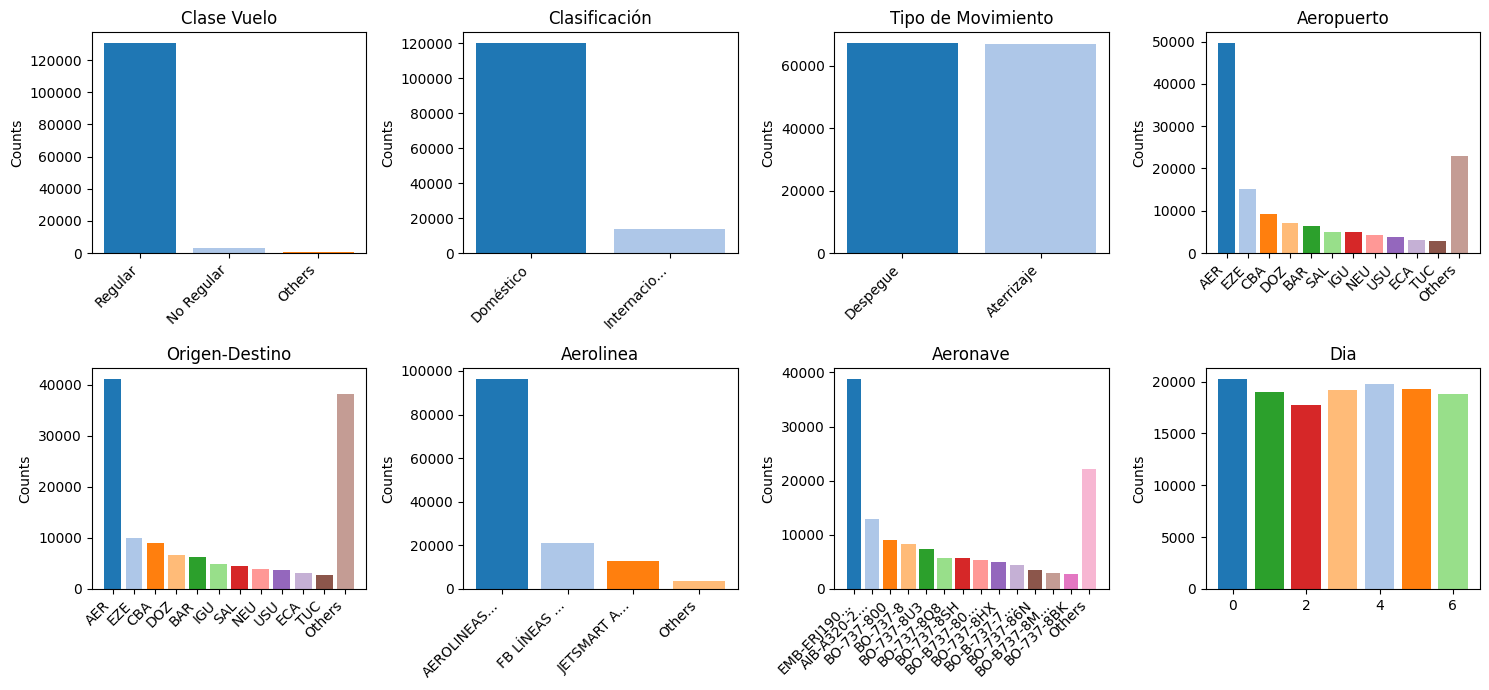

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 7))
ax = ax.flatten()

threshold = 2
colors = plt.get_cmap('tab20').colors

for i in range(len(cat_cols)):
    values = df[cat_cols[i]].value_counts()
    total = values.sum()
    percentages = (values / total) * 100
    
    above_threshold = values[percentages >= threshold]
    below_threshold = values[percentages < threshold]
    
    if below_threshold.size > 0:
        others = below_threshold.sum()
        above_threshold['Others'] = others

    final_percentages = (above_threshold / total) * 100
    
    ax[i].bar(above_threshold.index, above_threshold, color=colors[:len(above_threshold)])
    ax[i].set_title(cat_cols[i])
    ax[i].set_ylabel('Counts')
    if i < 7:
        truncated_labels = [label[:10] + '...' if len(label) > 10 else label for label in above_threshold.index]
        ax[i].set_xticks(range(len(truncated_labels)))
        ax[i].set_xticklabels(truncated_labels, rotation=45, ha='right')

plt.tight_layout()


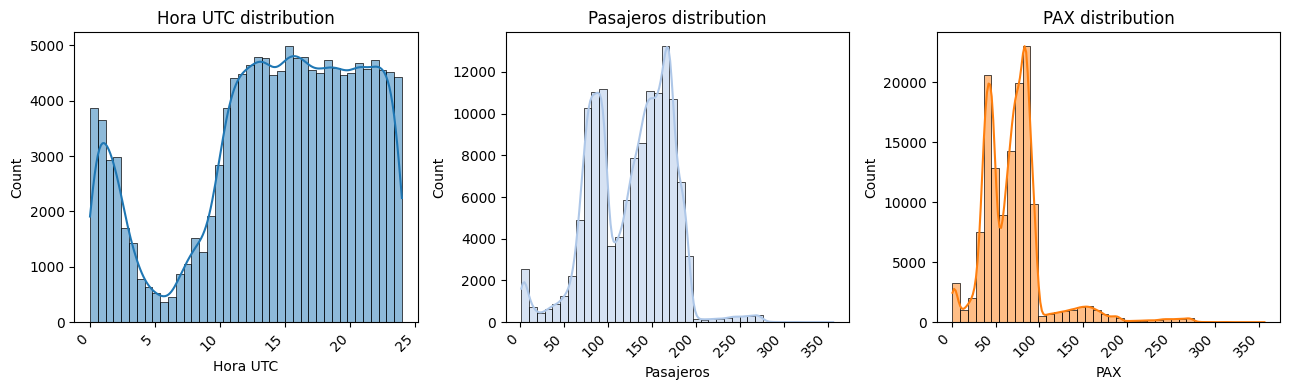

In [33]:
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13, 4))
ax = ax.flatten()

for i in range(len(num_cols)):
    sns.histplot(x=df[num_cols[i]], ax=ax[i], kde=True, color=colors[i], bins=40)
    ax[i].set_title(f'{num_cols[i]} distribution')
    
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha='right')

plt.subplots_adjust(hspace=0.4)
plt.tight_layout()

In [34]:
num_cols, cat_cols

(['Hora UTC', 'Pasajeros', 'PAX'],
 ['Clase Vuelo',
  'Clasificación',
  'Tipo de Movimiento',
  'Aeropuerto',
  'Origen-Destino',
  'Aerolinea',
  'Aeronave',
  'Dia'])

## Passengers prediction

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the features (X) and the target (y)
X = df.drop(columns='Pasajeros')
y = df['Pasajeros']

num_features = [column for column in num_cols if column != 'Pasajeros']
cat_features = cat_cols

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=30,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=1310
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

r2 = r2_score(y_test, y_pred)

In [49]:
print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'R²: {r2:.4f}')
oob_score = rf.oob_score_
print(f"OOB Score: {oob_score:.4f}")


Root Mean Squared Error: 12.7961
R²: 0.9213
OOB Score: 0.9190
